In [152]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation

# Camera calibration

In [153]:
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def Pi(points):
    n,p = points.shape
    new_points = np.vstack((points, np.ones(p)))
    return new_points

def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

def projectpoints(K,R,t,Q):
    homogeneous = Pi(Q)
    P = K @ ( np.hstack((R,t)) )
    q = P @ homogeneous
    q = PiInv(q)
    return q

def CrossOp(p):
    M = np.array([[0, -p[2], p[1]],[p[2], 0, -p[0]],[-p[1], p[0], 0]]) 
    return M

# Direct linear transform (DLT)

## Exercise 4.1

In [154]:
f = 1000
alpha, beta = 1, 0
dx, dy = 1920/2, 1080/2

K = np.array([[f, beta*f, dx],
              [0, alpha*f, dy],
              [0, 0, 1]])
R = np.array([[1/np.sqrt(2), -1/np.sqrt(2), 0],
              [1/np.sqrt(2),  1/np.sqrt(2), 0],
              [0, 0, 1]])
t = np.array([[0], 
              [0], 
              [10]])

P = K @ ( np.hstack((R,t)) )

Q = np.array([[0,0,0,0,1,1,1,1], 
              [0,0,1,1,0,0,1,1], 
              [0,1,0,1,0,1,0,1]])
q = projectpoints(K,R,t,Q)

In [155]:
P, q

(array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
          9.60000000e+03],
        [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
          5.40000000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          1.00000000e+01]]),
 array([[ 960.        ,  960.        ,  889.28932188,  895.71756535,
         1030.71067812, 1024.28243465,  960.        ,  960.        ],
        [ 540.        ,  540.        ,  610.71067812,  604.28243465,
          610.71067812,  604.28243465,  681.42135624,  668.56486931]]))

## Exercise 4.2

In [156]:
def normalize2d(p):
    mu = np.mean(p,axis=1)
    sigma = np.std(p,axis=1)
    Tinv = np.array([[sigma[0],0,mu[0]],
                     [0,sigma[1],mu[1]],
                     [0,0,1]])
    T = np.linalg.inv(Tinv)
    return T

def normalize3d(p):
    mu = np.mean(p,axis=1)
    sigma = np.std(p,axis=1)
    Tinv = np.array([[sigma[0],0,0,mu[0]],
                     [0,sigma[1],0,mu[1]],
                     [0,0,sigma[2],mu[2]],
                     [0,0,0,1]])
    T = np.linalg.inv(Tinv)
    return T

def pest(q1,q2,normalize = False):
    n,p = q1.shape
    
    if normalize == True:
        T1 = normalize2d(q1)
        T2 = normalize3d(q2)
        q1 = T1 @ Pi(q1)
        q2 = T2 @ Pi(q2)
    else:
        q1 = Pi(q1)
        q2 = Pi(q2)
    
    B = np.zeros((3*p,12))
    for i in range(p):
        M = np.array([[0,-1,q1[1,i]],
                      [1,0,-q1[0,i]],
                      [-q1[1,i],q1[0,i],0]])
        Bi = np.kron(q2[:,i], M)
        B[i*3:(i+1)*3,:] = Bi
        
    H = np.linalg.svd(B)[2][-1,:].reshape(4,3).T
    
    if normalize == True:
        H = np.linalg.inv(T1) @ H @ T2
        
    return H

In [157]:
Pest = pest(q,Q,normalize = False)
qest = PiInv(Pest @ Pi(Q))

In [158]:
Pest/Pest[0,0]*P[0,0] - P

array([[ 0.00000000e+00, -2.50111043e-12, -1.45519152e-11,
        -3.27418093e-10],
       [-8.75388650e-12, -4.09272616e-11, -7.50333129e-12,
        -1.83717930e-10],
       [ 7.56329871e-13, -4.03861219e-13, -1.69975145e-13,
        -4.20996571e-13]])

In [159]:
np.sqrt(np.sum((qest-q)**2)/12)

3.7429898628801925e-11

In [160]:
# With normalization
Pest = pest(q,Q,normalize = True)
qest = PiInv(Pest @ Pi(Q))
np.sqrt(np.sum((qest-q)**2)/12)

1.6077746776921858e-13

# Checkerboard calibration

## Exercise 4.3

In [161]:
def checkerboard_points(n, m):
    # allocate mem
    Q = np.zeros((3,m*n)) 
    
    li = np.arange(n) - (n-1)/2
    lj = np.arange(m) - (m-1)/2
    
    c = 0 
    for i in range(n):
        for j in range(m):
            Q[0,c] = li[i]
            Q[1,c] = lj[j]
            c += 1
    return Q

In [162]:
Q = checkerboard_points(10, 20)

## Exercise 4.4

In [163]:
Ra = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix()
Rb = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()
Rc = Rotation.from_euler('xyz', [-np.pi/10, 0, 0]).as_matrix()

Qa = Ra @ Q
Qb = Rb @ Q
Qc = Rc @ Q

qa = projectpoints(K,R,t,Qa)
qb = projectpoints(K,R,t,Qb)
qc = projectpoints(K,R,t,Qc)

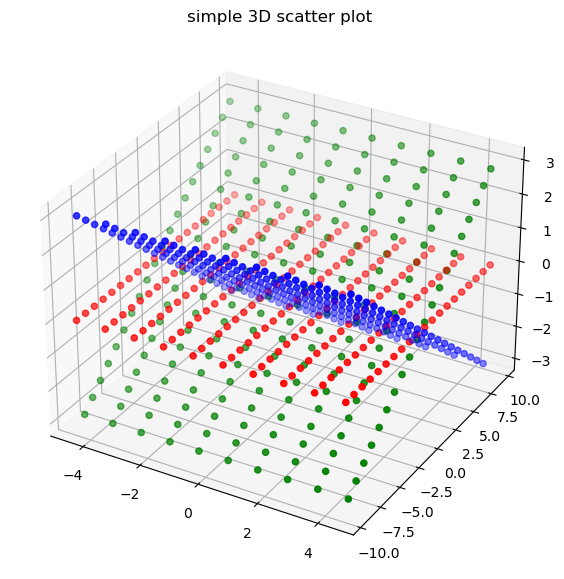

In [164]:
from mpl_toolkits import mplot3d
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(Qa[0,:], Qa[1,:], Qa[2,:], color = "green")
ax.scatter3D(Qb[0,:], Qb[1,:], Qb[2,:], color = "red")
ax.scatter3D(Qc[0,:], Qc[1,:], Qc[2,:], color = "blue")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

## Exercise 4.5

In [165]:
def estimateHomographies(Q_omega, qs):
    Hs = []
    Q_omega = Q_omega[0:2,:]
    for k in range(len(qs)):
        n,p = qs[k].shape
        qsk = Pi(qs[k])
        Q_omega = Pi(Q_omega[0:2,:])

        B = np.zeros((3*p,9))
        for i in range(p):
            M = np.array([[0,-1,qsk[1,i]],
                          [1,0,-qsk[0,i]],
                          [-qsk[1,i],qsk[0,i],0]])
            Bi = np.kron(Q_omega[:,i], M)
            B[i*3:(i+1)*3,:] = Bi

        H = np.linalg.svd(B)[2][-1,:].reshape(3,3).T
        Hs.append(H)
    return Hs

In [ ]:
qs

[array([[ 1.41393568e+03,  1.30370468e+03,  1.20234158e+03,
          1.10881765e+03,  1.02225735e+03,  9.41910843e+02,
          8.67132225e+02,  7.97362108e+02,  7.32113610e+02,
          6.70960976e+02,  6.13530275e+02,  5.59491750e+02,
          5.08553482e+02,  4.60456112e+02,  4.14968426e+02,
          3.71883639e+02,  3.31016250e+02,  2.92199372e+02,
          2.55282456e+02,  2.20129339e+02,  1.51403094e+03,
          1.39960495e+03,  1.29438434e+03,  1.19730123e+03,
          1.10744676e+03,  1.02404257e+03,  9.46418148e+02,
          8.73992836e+02,  8.06261219e+02,  7.42781339e+02,
          6.83165036e+02,  6.27070004e+02,  5.74193212e+02,
          5.24265433e+02,  4.77046653e+02,  4.32322216e+02,
          3.89899564e+02,  3.49605458e+02,  3.11283620e+02,
          2.74792704e+02,  1.61412620e+03,  1.49550522e+03,
          1.38642711e+03,  1.28578482e+03,  1.19263618e+03,
          1.10617429e+03,  1.02570407e+03,  9.50623563e+02,
          8.80408828e+02,  8.14601703e+0

In [166]:
qs = [qa,qb,qc]
Hs = estimateHomographies(Q, qs)

In [16]:
# test function
Qtild= Pi(Q[0:2,:])
for j in range(3):
    print('err : ', np.sqrt(np.sum((qs[j] - PiInv(Hs[j]@Qtild))**2)))

err :  4.873557109936342e-09
err :  8.756896286912555e-09
err :  5.523326004805451e-09


## Exercise 4.6

In [17]:
def vi_ab(H,a,b):
    return np.array([H[0,a]*H[0,b], H[0,a]*H[1,b] + H[1,a]*H[0,b], H[1,a]*H[1,b], H[2,a]*H[0,b] + H[0,a]*H[2,b],
                     H[2,a]*H[1,b] + H[1,a]*H[2,b], H[2,a]*H[2,b]])

In [68]:
def estimate_b(Hs):
    N = len(Hs)
    V = np.zeros((2*N,6))
    for i in range(N):
        vi_12 = vi_ab(Hs[i],0,1)
        vi_11 = vi_ab(Hs[i],0,0)
        vi_22 = vi_ab(Hs[i],1,1)
        
        V[i*2,:] = vi_12
        V[i*2+1,:] = vi_11 - vi_22
        
    b = np.linalg.svd(V)[2][-1,:]
    return b

In [69]:
best = estimate_b(Hs)
best

array([-4.51834392e-07,  4.27681074e-19, -4.51834392e-07,  4.33761016e-04,
        2.43990572e-04, -9.99999876e-01])

In [72]:
# testing
Btrue = np.linalg.inv(K).T @ np.linalg.inv(K)
btrue = np.array([Btrue[0,0], Btrue[0,1], Btrue[1,1], Btrue[0,2], Btrue[1,2], Btrue[2,2]])
print('err : ', btrue - best/best[0]*btrue[0])

err :  [ 0.00000000e+00  9.46543870e-19 -2.07099556e-19  3.07046055e-16
 -1.40198183e-15  6.00763883e-12]


In [73]:
# debugging
i = 0
Hi = Hs[i][:,0]
v11 = vi_ab(Hs[i],0,0)
v11*btrue - Hi.T @ Btrue @ Hi

array([-4.05956533e-09, -8.11913067e-09, -4.05956533e-09, -8.11913067e-09,
       -8.11913067e-09, -8.11913067e-09])

## Exercise 4.7

In [115]:
def estimateIntrisics(Hs):
    b = estimate_b(Hs)
    
    v0 = (b[1]*b[3] - b[0]*b[4])/(b[0]*b[2] - b[1]**2)
    lambda_ = b[5] - (b[3]**2 + v0*(b[1]*b[3] - b[0]*b[4]))/b[0]
    alpha = np.sqrt(lambda_/b[0])
    beta = np.sqrt(lambda_*b[0]/(b[0]*b[2] - b[1]**2))
    gamma = -b[1]*alpha**2*beta/lambda_
    u0 = gamma*v0/beta - b[3]*alpha**2/lambda_
                   
    K = np.array([[alpha, gamma, u0],
              [0, beta, v0],
              [0, 0, 1]])
                   
    return K

In [76]:
Kest = estimateIntrisics(Hs)
print('err : ', Kest -K)

-0.4518343919015405
err :  [[-3.00201464e-09  9.46543870e-10  8.18204171e-10]
 [ 0.00000000e+00 -3.10558335e-09 -6.05155037e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


## Exercise 4.8

In [145]:
def estimateExtrinsics(K, Hs):
    N = len(Hs)
    Rs = []
    ts = []
    for i in range(N):
        Ri = np.zeros((3,3))
        
        Hi = Hs[i]
        mem = np.linalg.inv(K) @ Hi[:,0]
        lambdai = np.sqrt(mem.T @ mem)
        
        Ri[:,0] = 1/lambdai * np.linalg.inv(K) @ Hi[:,0]
        Ri[:,1] = 1/lambdai * np.linalg.inv(K) @ Hi[:,1]
        ti      = 1/lambdai * np.linalg.inv(K) @ Hi[:,2]
        Ri[:,2] = CrossOp(Ri[:,0]) @ Ri[:,1]
        
        Rs.append(Ri)
        ts.append(ti)
    return Rs, ts

In [146]:
Rs, ts = estimateExtrinsics(K, Hs)

In [147]:
t, ts

(array([[ 0],
        [ 0],
        [10]]),
 [array([-1.11910481e-13, -5.95079541e-14,  1.00000000e+01]),
  array([ 1.82964754e-13,  1.12798659e-13, -1.00000000e+01]),
  array([-1.22568622e-13, -6.92779167e-14, -1.00000000e+01])])

Ok but not always the right sign.

In [148]:
Rs

[array([[ 7.07106781e-01, -6.72498512e-01,  2.18508012e-01],
        [ 7.07106781e-01,  6.72498512e-01, -2.18508012e-01],
        [-8.08133162e-13,  3.09016994e-01,  9.51056516e-01]]),
 array([[-7.07106781e-01,  7.07106781e-01, -1.07762761e-14],
        [-7.07106781e-01, -7.07106781e-01,  9.90737396e-13],
        [ 6.92937153e-13,  7.08177109e-13,  1.00000000e+00]]),
 array([[-7.07106781e-01,  6.72498512e-01, -2.18508012e-01],
        [-7.07106781e-01, -6.72498512e-01,  2.18508012e-01],
        [ 2.85042641e-13,  3.09016994e-01,  9.51056516e-01]])]

In [149]:
Rs[0]- R @ Ra

array([[ 1.69753100e-13,  6.54032384e-13,  2.47801779e-13],
       [-1.69531056e-13, -5.33795230e-13,  7.34329264e-13],
       [-8.08133162e-13, -3.44058115e-13, -8.39994740e-13]])

In [150]:
Rs[1]- R @ Rb ## smthing wrong

array([[-1.41421356e+00,  1.41421356e+00, -1.07762761e-14],
       [-1.41421356e+00, -1.41421356e+00,  9.90737396e-13],
       [ 6.92937153e-13,  7.08177109e-13, -9.46132062e-13]])

In [151]:
Rs[2]- R @ Rc ## smthing wrong

array([[-1.41421356e+00,  1.34499702e+00,  6.06181771e-13],
       [-1.41421356e+00, -1.34499702e+00, -1.85712556e-13],
       [ 2.85042641e-13,  6.18033989e-01, -1.48325796e-13]])

In [113]:
def calibratecamera(qs, Q):
    Hs = estimateHomographies(Q, qs)
    Kest = estimateIntrisics(Hs)
    Rs, ts = estimateExtrinsics(Kest, Hs)
    return K, Rs, ts

In [116]:
calibratecamera(qs, Q)

(array([[1000.,    0.,  960.],
        [   0., 1000.,  540.],
        [   0.,    0.,    1.]]),
 [array([[ 7.07106781e-01, -6.72498512e-01,  2.18508012e-01],
         [ 7.07106781e-01,  6.72498512e-01, -2.18508012e-01],
         [-8.08133162e-13,  3.09016994e-01,  9.51056516e-01]]),
  array([[-7.07106781e-01,  7.07106781e-01, -1.07762761e-14],
         [-7.07106781e-01, -7.07106781e-01,  9.90737396e-13],
         [ 6.92937153e-13,  7.08177109e-13,  1.00000000e+00]]),
  array([[-7.07106781e-01,  6.72498512e-01, -2.18508012e-01],
         [-7.07106781e-01, -6.72498512e-01,  2.18508012e-01],
         [ 2.85042641e-13,  3.09016994e-01,  9.51056516e-01]])],
 [array([-8.29381008e-12,  5.99253980e-12,  1.00000000e+01]),
  array([ 8.36486436e-12, -5.93924909e-12, -1.00000000e+01]),
  array([ 8.05933098e-12, -6.12043749e-12, -1.00000000e+01])])